In [2]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# Load the trained model
model_age = load_model('../models/best_age_model.keras')
model_emotion = load_model('../models/best_emotion_model.keras')
model_gender = load_model('../models/best_gender_model.keras')

In [4]:
# Define dictionaries for gender and emotion labels
gender_dict = {0: 'Male', 1: 'Female'}
emotion_labels = {
    'Angry': 'Angry 😠',
    'Happy': 'Happy 😃',
    'Neutral': 'Neutral 😐',
    'Sad': 'Sad 😢',
    'Surprised': 'Surprised 😲'
}

In [5]:
def preprocess_image(img):
    # Convert to grayscale if the image is in color
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, 
                                          minNeighbors=5, 
                                          minSize=(50, 50),
                                          flags=cv2.CASCADE_SCALE_IMAGE)
    
    if len(faces) > 0:
        faces = sorted(faces, key=lambda x: x[2] * x[3], reverse=True)
        (x, y, w, h) = faces[0]
        
        if w > 50 and h > 50:
            face = gray[y:y+h, x:x+w]
            face = cv2.resize(face, (128, 128))
            face = face.astype('float32') / 255.0
            face = np.expand_dims(face, axis=-1)
            face = np.expand_dims(face, axis=0)
            return face, (x, y, w, h)
    return None, None

In [26]:
def predict_from_image(img):
    processed_img, face_bbox = preprocess_image(img)
    
    if processed_img is not None:
        # Make predictions from the models
        pred_age = model_age.predict(processed_img)[0][0]
        pred_emotion = model_emotion.predict(processed_img)[0]
        pred_gender = model_gender.predict(processed_img)[0][0]

        # Process predictions
        pred_gender_label = gender_dict[1 if pred_gender > 0.7 else 0]
        gender_confidence = max(pred_gender, 1 - pred_gender)

        # Age prediction with range
        pred_age_value = max(1, int(pred_age))
        range_width = max(2, int(0.05 * pred_age_value))  # 5% of the predicted age, minimum range of 2
        pred_age_lower = max(1, pred_age_value - range_width)
        pred_age_upper = pred_age_value + range_width

        # Calculate age confidence (as a basic example, confidence could decrease with wider ranges)
        age_confidence = 1 - (range_width / pred_age_value) if pred_age_value > 0 else 0
        age_confidence = max(0, min(1, age_confidence))  # Keep confidence between 0 and 1

        # Emotion prediction
        emotion_label = list(emotion_labels.keys())[np.argmax(pred_emotion)]
        pred_emotion_label = emotion_labels[emotion_label]
        emotion_confidence = np.max(pred_emotion)

        print(f"Predicted Gender: {pred_gender_label} (My confidence is: {gender_confidence * 100:.2f}%)")
        print(f"Predicted Age: {pred_age_lower}-{pred_age_upper} (My confidence for age is around: {age_confidence * 100:.2f}%)")
        print(f"Predicted Emotion: {pred_emotion_label} (Here I am {emotion_confidence * 100:.2f}% confident.)")

        # Draw a bounding box around the detected face
        if face_bbox is not None:
            (x, y, w, h) = face_bbox
            img_with_bbox = img.copy() if len(img.shape) == 3 else cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            cv2.rectangle(img_with_bbox, (x, y), (x + w, y + h), (0, 255, 0), 2)
            plt.imshow(img_with_bbox, cmap='gray' if len(img.shape) == 2 else None)
            plt.axis('off')
            plt.show()

        return {
            'gender': pred_gender_label,
            'gender_confidence': gender_confidence,
            'age_range': f"{pred_age_lower}-{pred_age_upper}",
            'age_confidence': age_confidence,
            'emotion': pred_emotion_label,
            'emotion_confidence': emotion_confidence
        }
    else:
        print("No face detected in the image.")
        return None

1/1 [==============================] - 0s 22ms/step
Predicted Gender: Male (My confidence is: 56.45%)
Predicted Age: 30-34 (My confidence for age is around: 93.75%)
Predicted Emotion: Surprised 😲 (Here I am 99.79% confident.)


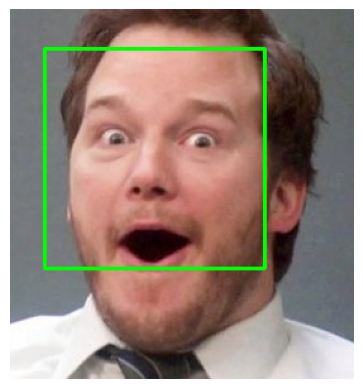

In [31]:
# image_path = '../dataset/image-examples/angelina_jolie.jpeg'
# image_path = '../dataset/image-examples/anne_hathaway.jpeg'
image_path = '../dataset/image-examples/chris_pratt.jpeg'
# image_path = '../dataset/image-examples/leonardo_dicaprio.jpeg'
# image_path = '../dataset/image-examples/madison_beer.jpeg'
# image_path = '../dataset/image-examples/matthew_mcConaughey.png'
# image_path = '../dataset/image-examples/meryl_streep.jpg'
# image_path = '../dataset/image-examples/rdj.jpeg'
# image_path = '../dataset/image-examples/samuel-l-jackson.jpeg'
# image_path = '../dataset/image-examples/tom_hanks.jpeg'

img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
result = predict_from_image(img_rgb)